# Feature Analysis & Selection

**Goal**: Analyze features to predict `y_paid_dues`, understand correlations, and select the best features for the Knight Hacks Dues Prediction project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configuration
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [2]:
# Load Data
data_path = '../data/knight_hacks_dues_dataset_2025.csv'
df = pd.read_csv(data_path)
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (838, 40)


,discordUser,member_days_since_join,events_attended_year,distinct_event_days_year,attendance_streak_weeks,n_gbm_year,gbm_ratio,n_social_year,social_ratio,n_hello_world_year,hello_world_ratio,n_sponsorship_year,sponsorship_ratio,n_tech_exploration_year,tech_exploration_ratio,n_class_support_year,class_support_ratio,n_workshop_year,workshop_ratio,n_ops_year,ops_ratio,n_collabs_year,collabs_ratio,feedback_count_year,avg_event_rating_given,left_any_feedback,has_gone_to_hackathon,discord_member,discord_days_since_join,has_role_ops,discord_msgs_year,discord_active_days_year,discord_channels_posted_year,discord_num_roles,level_of_study,major,school,gender,race_or_ethnicity,y_paid_dues
0,paddlewaddle,84,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,1,1177.0,0,0,0,0,12,Undergraduate University (3+ year),Computer Science,University of Central Florida,Woman,Asian,1.0
1,rhygon_,74,6,6,3,0,NaN,1,0.166667,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,5,0.833333,0,NaN,0,NaN,0,1,1,142.0,1,1594,45,9,18,Undergraduate University (3+ year),Computer Science,University of Central Florida,Man,Asian,1.0
2,funjack17,64,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,1,1,443.0,0,0,0,0,7,Undergraduate University (2 year - community c...,Computer Science,University of Central Florida,Man,Hispanic / Latino / Spanish Origin,1.0
3,million,308,8,13,9,2,0.25,0,NaN,0,NaN,0,NaN,0,NaN,1,0.125,0,NaN,5,0.625000,0,NaN,0,NaN,0,1,1,449.0,1,3328,161,13,15,Undergraduate University (3+ year),Computer Science,University of Central Florida,Man,White,1.0
4,airforcemot,308,4,8,3,1,0.25,0,NaN,0,NaN,0,NaN,1,0.25,2,0.500,0,NaN,0,NaN,0,NaN,0,NaN,0,1,1,414.0,0,2,1,1,5,Undergraduate University (3+ year),Computer Science,University of Central Florida,Man,Asian,1.0


## 1. Data Overview & Missing Values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   discordUser                   838 non-null    object 
 1   member_days_since_join        838 non-null    int64  
 2   events_attended_year          838 non-null    int64  
 3   distinct_event_days_year      838 non-null    int64  
 4   attendance_streak_weeks       838 non-null    int64  
 5   n_gbm_year                    838 non-null    int64  
 6   gbm_ratio                     219 non-null    float64
 7   n_social_year                 838 non-null    int64  
 8   social_ratio                  47 non-null     float64
 9   n_hello_world_year            838 non-null    int64  
 10  hello_world_ratio             170 non-null    float64
 11  n_sponsorship_year            838 non-null    int64  
 12  sponsorship_ratio             116 non-null    float64
 13  n_tec

In [4]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0]

gbm_ratio                  619
social_ratio               791
hello_world_ratio          668
sponsorship_ratio          722
tech_exploration_ratio     782
class_support_ratio        730
workshop_ratio             819
ops_ratio                  653
collabs_ratio              773
avg_event_rating_given     810
discord_days_since_join     59
gender                      24
race_or_ethnicity           24
y_paid_dues                 24
dtype: int64

### Imputation Strategy (from DATA.md)
- All event ratio fields (`gbm_ratio`, `social_ratio`, `hello_world_ratio`, `sponsorship_ratio`, `tech_exploration_ratio`, `class_support_ratio`, `workshop_ratio`, `ops_ratio`, `collabs_ratio`): 0 if null (no events = no specific types)
- `avg_event_rating_given`: Mean imputation
- `discord_days_since_join`: -1 when `discord_member = 0` (not a member)
- `gender`, `race_or_ethnicity`: Fill with "Prefer not to answer" for missing values
- `y_paid_dues`: Fill with 0 for missing values (assume not paid)

In [6]:
# Implement Imputation

# All event ratio fields: 0 when null (no events = no specific types)
event_ratio_cols = [
    'gbm_ratio', 'social_ratio', 'hello_world_ratio', 'sponsorship_ratio',
    'tech_exploration_ratio', 'class_support_ratio', 'workshop_ratio',
    'ops_ratio', 'collabs_ratio'
]
for col in event_ratio_cols:
    df[col] = df[col].fillna(0)

# avg_event_rating_given: Mean imputation
mean_rating = df['avg_event_rating_given'].mean()
df['avg_event_rating_given'] = df['avg_event_rating_given'].fillna(mean_rating)

# discord_days_since_join: -1 when not a member
df['discord_days_since_join'] = df['discord_days_since_join'].fillna(-1)

# Categorical missing values
df['gender'] = df['gender'].fillna('Prefer not to answer')
df['race_or_ethnicity'] = df['race_or_ethnicity'].fillna('Prefer not to answer')

# Target variable: assume 0 (not paid) for missing
df['y_paid_dues'] = df['y_paid_dues'].fillna(0)

# Verify no missing left
print("Remaining missing values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Remaining missing values:
Series([], dtype: int64)

Total missing values: 0


## 2. Target Distribution

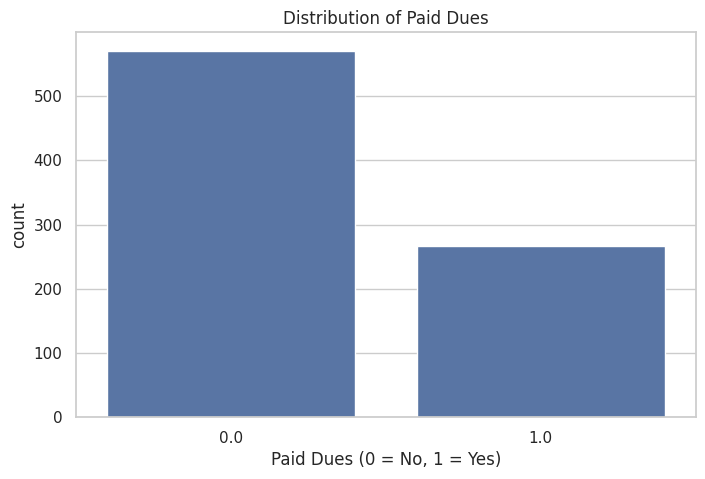

y_paid_dues
0.0    0.681384
1.0    0.318616
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='y_paid_dues', data=df)
plt.title('Distribution of Paid Dues')
plt.xlabel('Paid Dues (0 = No, 1 = Yes)')
plt.show()

print(df['y_paid_dues'].value_counts(normalize=True))

## 3. Correlation Analysis

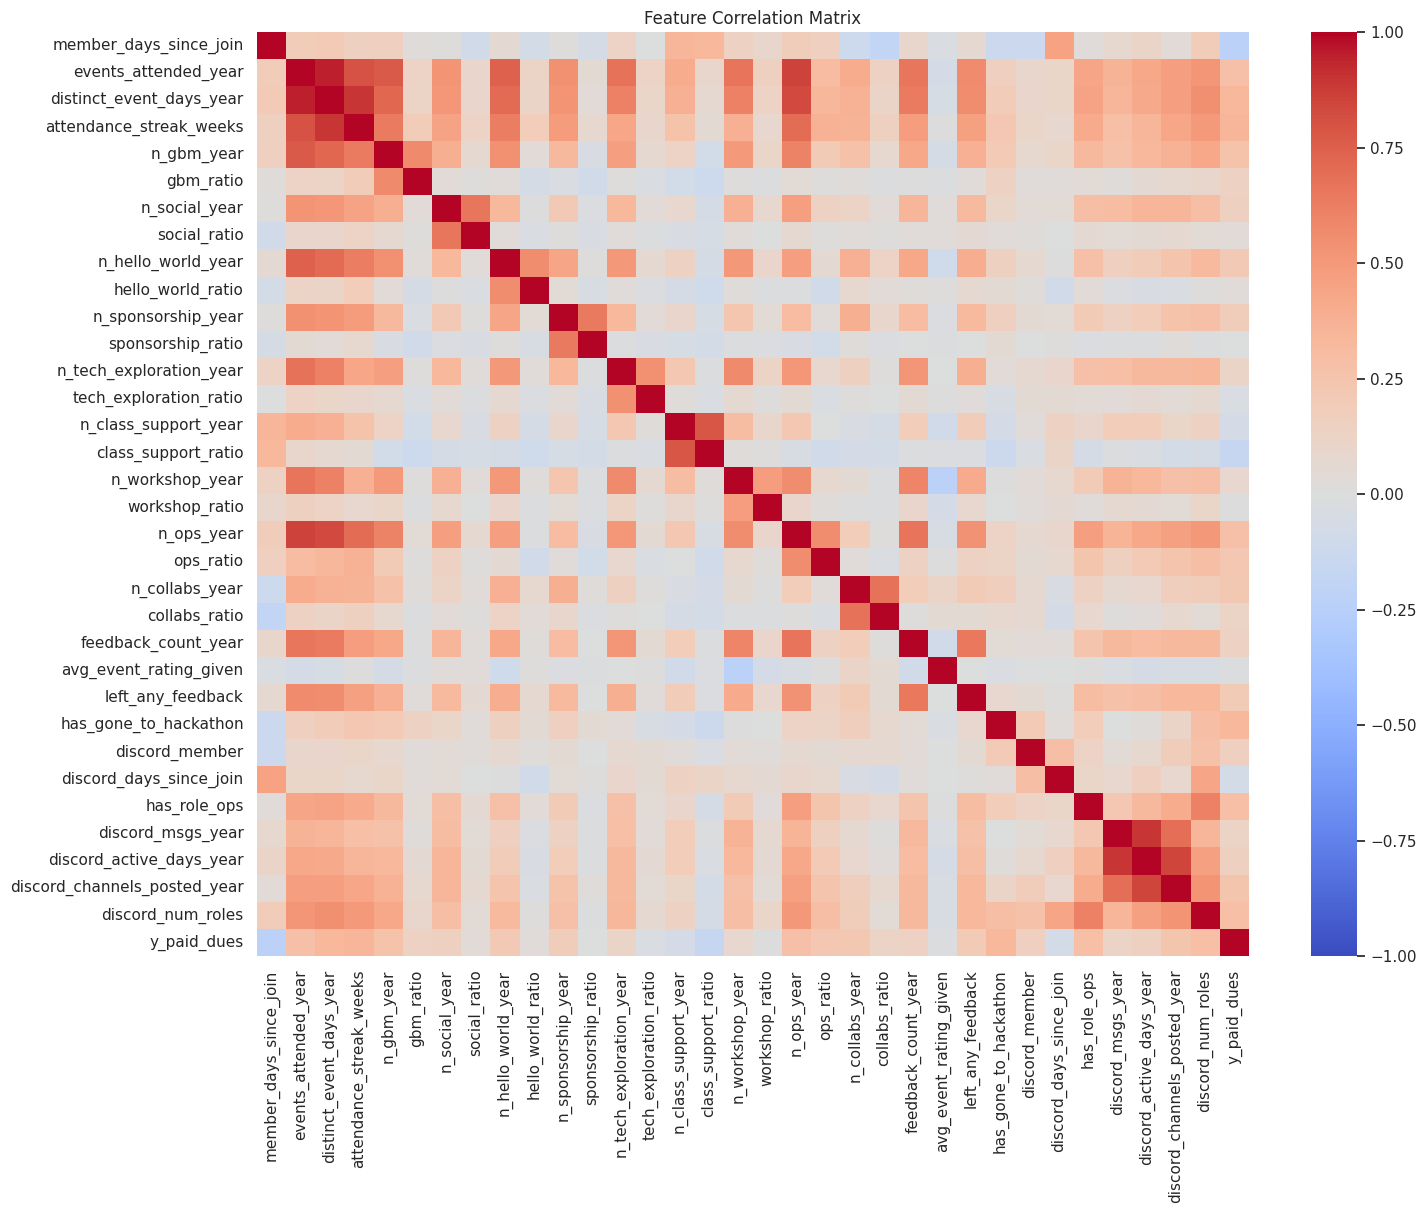

Top Positive Correlations:
 attendance_streak_weeks         0.349442
has_gone_to_hackathon           0.334707
distinct_event_days_year        0.332461
has_role_ops                    0.286845
discord_num_roles               0.283955
n_ops_year                      0.275177
events_attended_year            0.273744
n_gbm_year                      0.264250
discord_channels_posted_year    0.242992
ops_ratio                       0.228113
Name: y_paid_dues, dtype: float64

Top Negative Correlations:
 social_ratio               0.031886
hello_world_ratio          0.030198
workshop_ratio             0.005756
sponsorship_ratio         -0.000451
avg_event_rating_given    -0.010985
tech_exploration_ratio    -0.031233
n_class_support_year      -0.063690
discord_days_since_join   -0.075814
class_support_ratio       -0.162321
member_days_since_join    -0.228677
Name: y_paid_dues, dtype: float64


In [8]:
# Numeric Correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlations with Target
target_corr = corr_matrix['y_paid_dues'].drop('y_paid_dues').sort_values(ascending=False)
print("Top Positive Correlations:\n", target_corr.head(10))
print("\nTop Negative Correlations:\n", target_corr.tail(10))

## 4. Feature Importance (XGBoost Baseline)

/home/dvidal1205/Dropbox/School Documents/Spring 2025/ISC 4241/final-project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [15:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


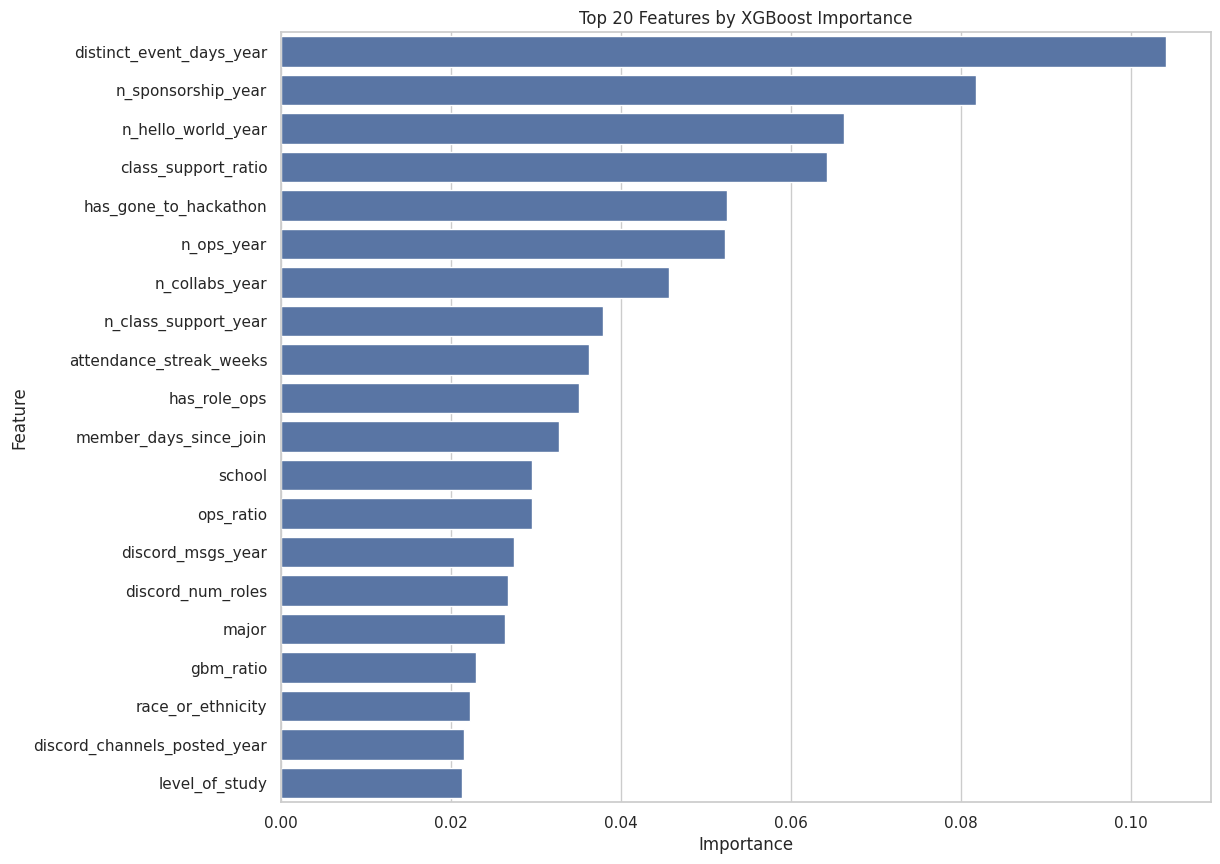

In [9]:
# Prepare data for XGBoost
# Drop identifiers and target
X = df.drop(['y_paid_dues', 'discordUser'], axis=1)
y = df['y_paid_dues']

# Encode Categoricals simple label encoding for feature importance check
X_encoded = X.copy()
cat_cols = X_encoded.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    # Convert to string to handle potential mixed types if any
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Extract Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features by XGBoost Importance')
plt.show()

## 5. Categorical Feature Analysis

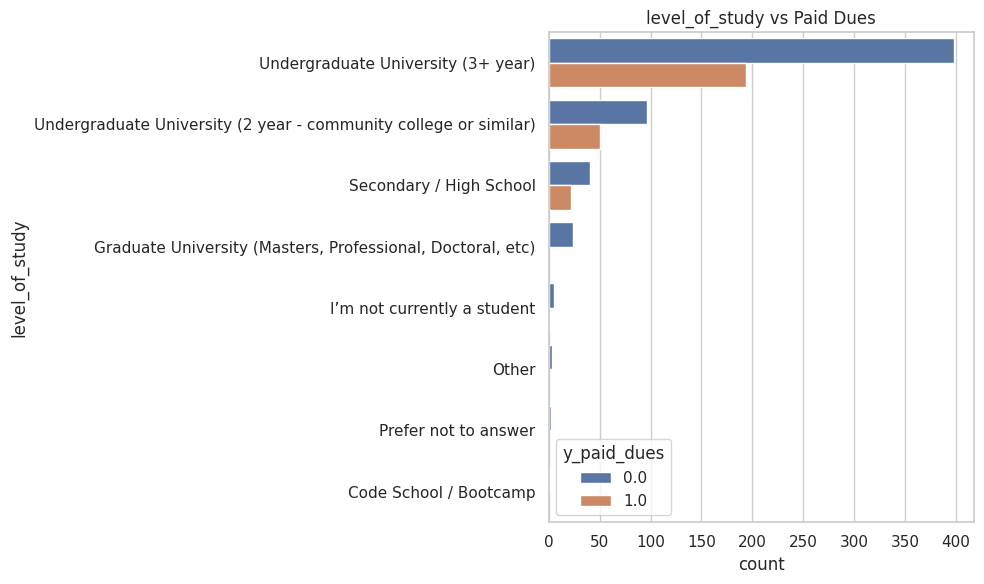

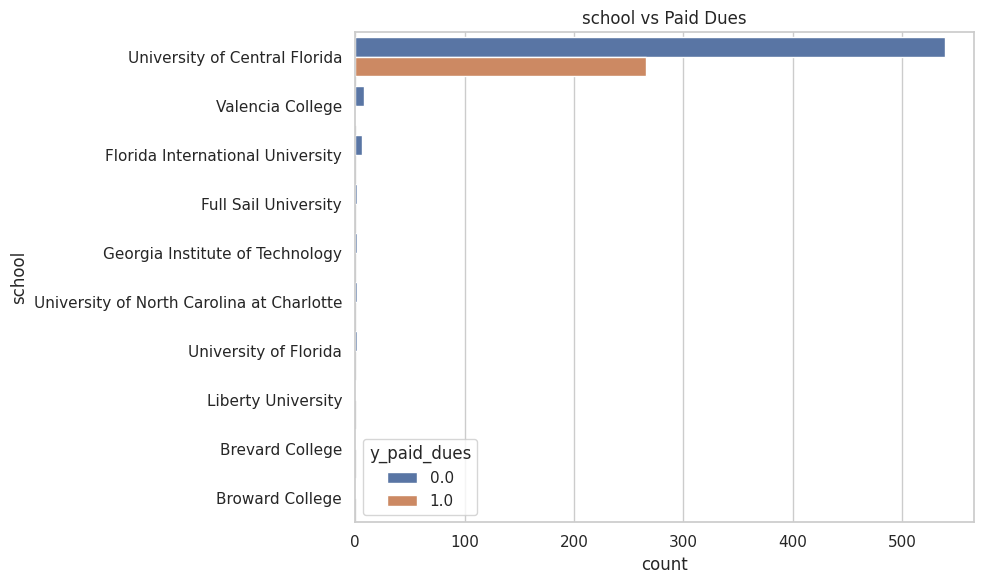

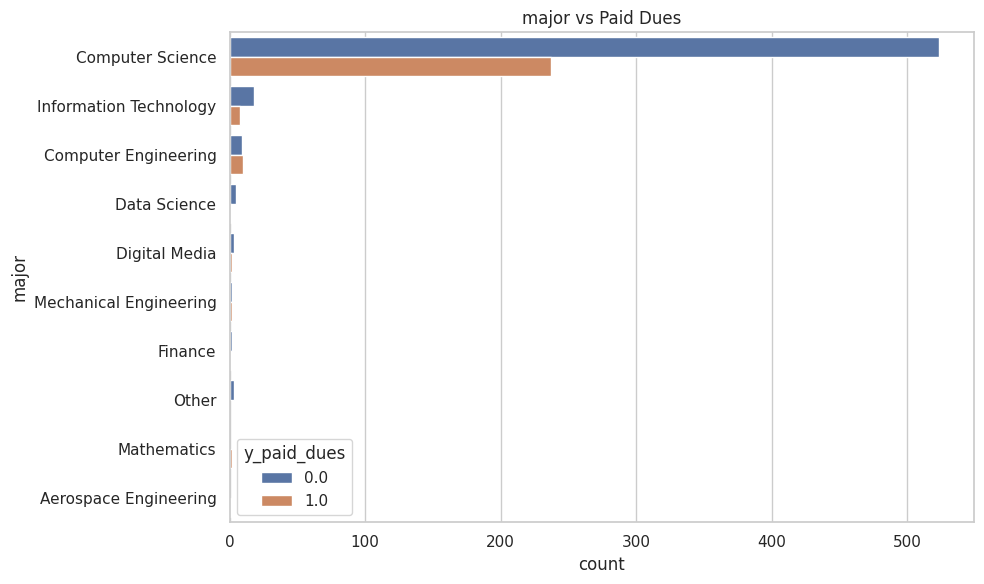

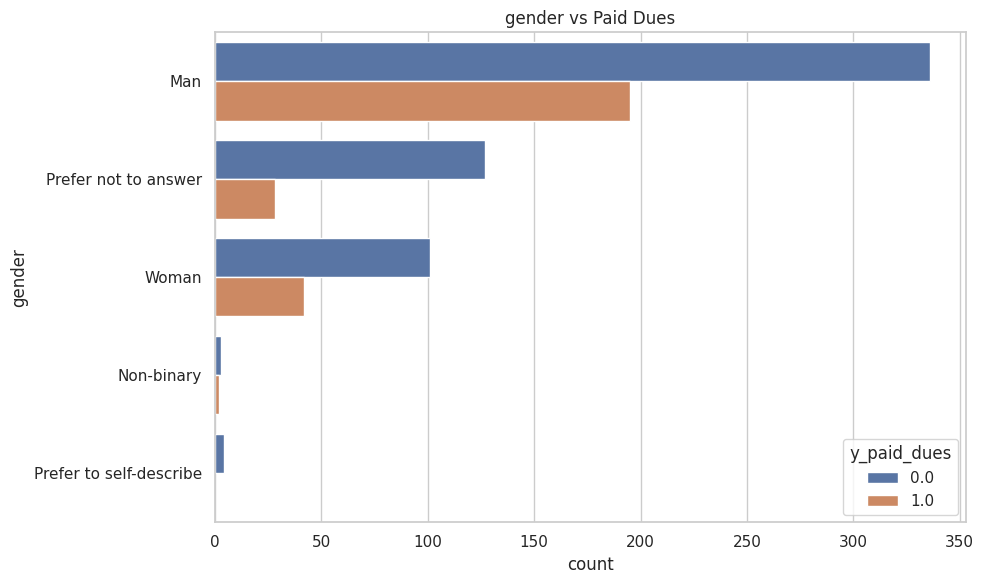

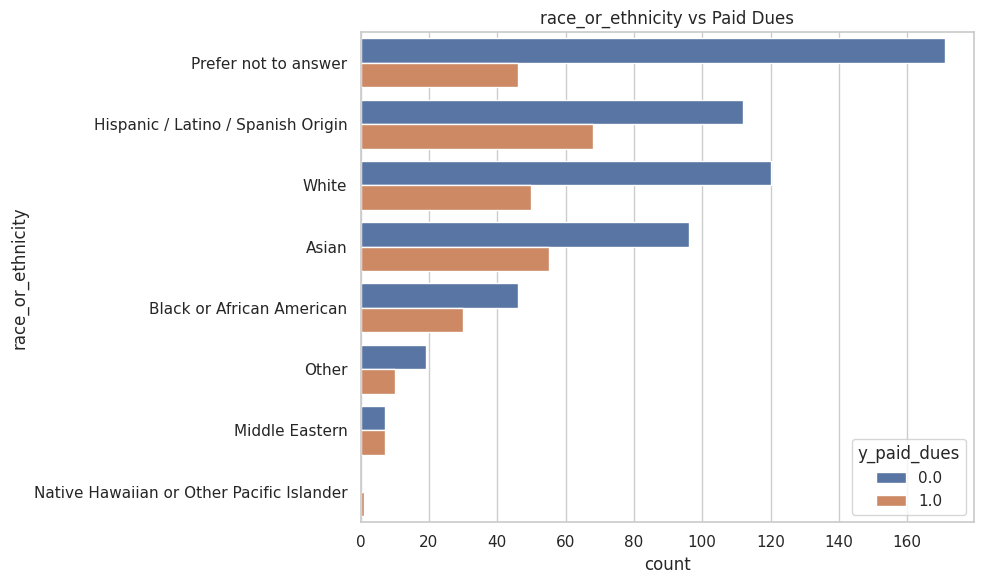

In [10]:
categorical_features = ['level_of_study', 'school', 'major', 'gender', 'race_or_ethnicity']

for col in categorical_features:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        # Order by count
        order = df[col].value_counts().iloc[:10].index # Top 10 categories if many
        sns.countplot(y=col, hue='y_paid_dues', data=df, order=order)
        plt.title(f'{col} vs Paid Dues')
        plt.tight_layout()
        plt.show()